<a href="https://colab.research.google.com/github/MohamedKhalidmk/GAN-for-Face-Image-Generation/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers as layer
import os
import time
from IPython import display

In [ ]:
dataset, info = tfds.load('celeb_a', split='train', with_info=True, shuffle_files=True)
info

tfds.core.DatasetInfo(
    name='celeb_a',
    full_name='celeb_a/2.1.0',
    description="""
    CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset
    with more than 200K celebrity images, each with 40 attribute annotations. The
    images in this dataset cover large pose variations and background clutter.
    CelebA has large diversities, large quantities, and rich annotations,
    including - 10,177 number of identities, - 202,599 number of face images, and -
    5 landmark locations, 40 binary attributes annotations per image.
    
    The dataset can be employed as the training and test sets for the following
    computer vision tasks: face attribute recognition, face detection, and landmark
    (or facial part) localization.
    
    Note: CelebA dataset may contain potential bias. The fairness indicators
    [example](https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_TFCO_CelebA_Case_Study)
    goes into det

In [ ]:
print(dataset)

<PrefetchDataset element_spec={'attributes': {'5_o_Clock_Shadow': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Arched_Eyebrows': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Attractive': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bags_Under_Eyes': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bald': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bangs': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Big_Lips': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Big_Nose': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Black_Hair': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Blond_Hair': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Blurry': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Brown_Hair': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Bushy_Eyebrows': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Chubby': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Double_Chin': TensorSpec(shape=(), dtype=tf.bool, name=None), 'Eyeglasses': TensorSpec(s

In [ ]:
def preprocess(features):
    image = features['image']
    # Crop center 178x178 (original size 218 height)
    # central_fraction = 178 / 218 ~ 0.8165
    image = tf.image.central_crop(image, central_fraction=178/218)
    #image resize
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

In [ ]:
batch_size=64
train_dataset=dataset.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset=train_dataset.shuffle(1000).batch(batch_size,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

(64, 64, 64, 3)


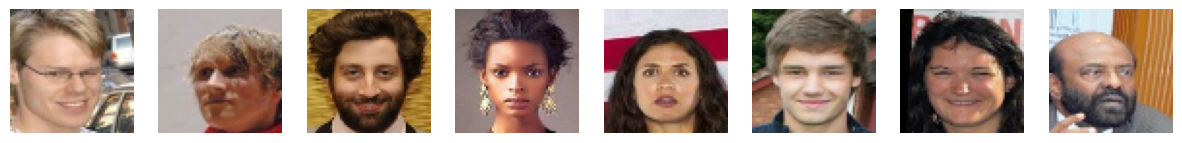

In [ ]:
for images in train_dataset.take(1):
    print(images.shape)
    imgs = (images + 1.0) / 2.0

    fig, axes = plt.subplots(1, 8, figsize=(15, 3))
    for i in range(8):
        axes[i].imshow(imgs[i])
        axes[i].axis('off')
    plt.show()

In [ ]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layer.Dense(8*8*256,use_bias=False,input_shape=(100,)))
    model.add(layer.BatchNormalization())
    model.add(layer.LeakyReLU())

    model.add(layer.Reshape((8,8,256)))
    assert model.output_shape == (None,8,8,256)

    model.add(layer.Conv2DTranspose(128,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None,16,16,128)
    model.add(layer.BatchNormalization())
    model.add(layer.LeakyReLU())

    model.add(layer.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None,32,32,64)
    model.add(layer.BatchNormalization())
    model.add(layer.LeakyReLU())

    model.add(layer.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    assert model.output_shape == (None,64,64,3)

    return model

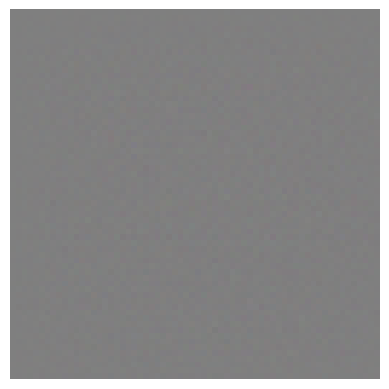

In [ ]:
generator=generator_model()
noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
generated_image_scaled = (generated_image[0,:,:,:] + 1.0) / 2.0
plt.axis('off')
plt.imshow(generated_image_scaled)

In [ ]:
def discriminator_model():
    model=tf.keras.Sequential()
    model.add(layer.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[64,64,3]))

    model.add(layer.LeakyReLU())
    model.add(layer.Dropout(0.3))

    model.add(layer.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layer.LeakyReLU())
    model.add(layer.Dropout(0.3))

    model.add(layer.Flatten())
    model.add(layer.Dense(1))

    return model

In [ ]:
discriminator=discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[4.2558328e-05]], shape=(1, 1), dtype=float32)


In [ ]:
generator.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_48 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_16 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_48 (Conv2D  (None, 16, 16, 128)      819200    
 Transpose)                                                      
                                                                 
 batch_normalization_49 (Bat  (None, 16, 16, 128)    

In [ ]:
discriminator.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_79 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_28 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_29 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 flatten_14 (Flatten)        (None, 32768)           

In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = r'C:\ML\checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Set the checkpoint prefix
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# Define your checkpoint object
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)
checkpoint.save(file_prefix=checkpoint_prefix)


'C:\\ML\\checkpoints\\ckpt-1'

In [ ]:
epochs=20
noise_dim=100
num_examples=16
seed=tf.random.normal([num_examples,noise_dim])
gen_losses = []
disc_losses = []

In [ ]:
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model,epoch,test_input):
    predictions=model(test_input,training=False)
    fig=plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i,:,:,:] + 1.0) / 2.0)
        plt.axis('off')
    plt.savefig(r'C:\Users\shado\Pictures\Screenshots\image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()
        for image_batch in dataset:
            gen_loss,disc_loss=train_step(image_batch)
            gen_losses.append(gen_loss.numpy())
            disc_losses.append(disc_loss.numpy())
        generate_and_save_images(generator,epoch+1,seed)
        if(epoch+1)%5==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f'Epoch {epoch+1}, Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}, Time: {time.time()-start:.2f} sec')
    generate_and_save_images(generator,epochs,seed)
    print(f'Epoch {epoch+1}, Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}, Time: {time.time()-start:.2f} sec')


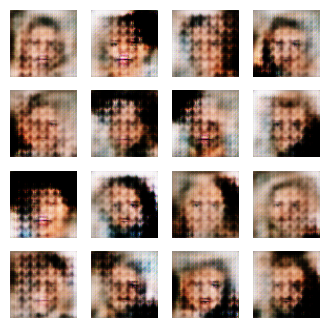

Epoch 1, Gen Loss: 1.1534, Disc Loss: 1.1281, Time: 214.81 sec


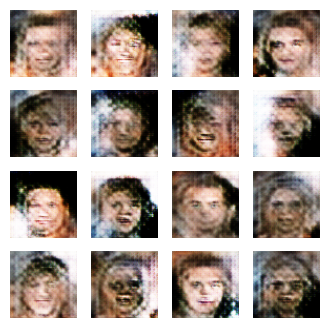

Epoch 2, Gen Loss: 1.6103, Disc Loss: 0.7052, Time: 201.16 sec


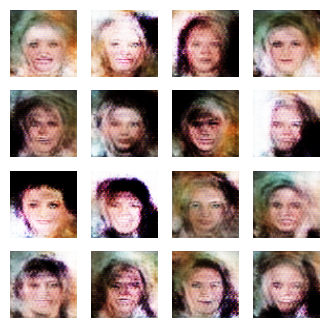

Epoch 3, Gen Loss: 1.8674, Disc Loss: 0.8449, Time: 199.10 sec


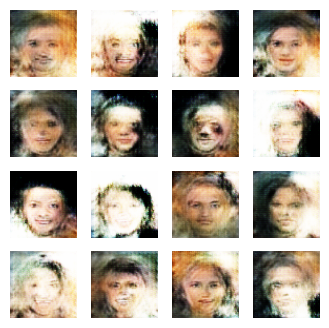

Epoch 4, Gen Loss: 1.0991, Disc Loss: 1.3958, Time: 195.03 sec


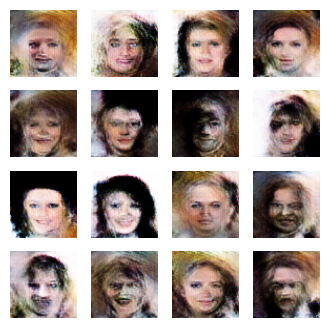

Epoch 5, Gen Loss: 1.1669, Disc Loss: 1.0481, Time: 197.67 sec


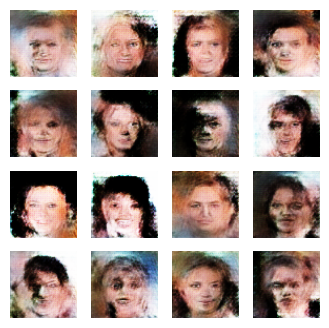

Epoch 6, Gen Loss: 1.6557, Disc Loss: 1.1984, Time: 194.68 sec


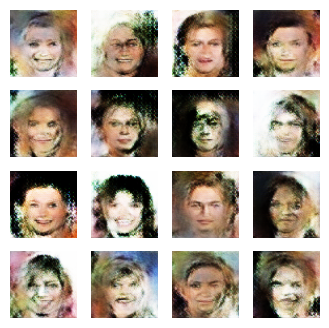

Epoch 7, Gen Loss: 1.4279, Disc Loss: 1.2686, Time: 195.68 sec


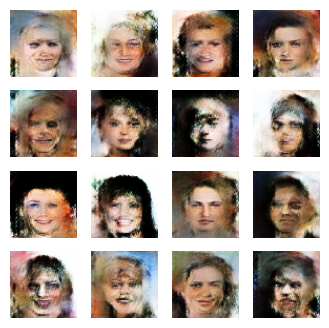

Epoch 8, Gen Loss: 2.1313, Disc Loss: 0.6375, Time: 195.81 sec


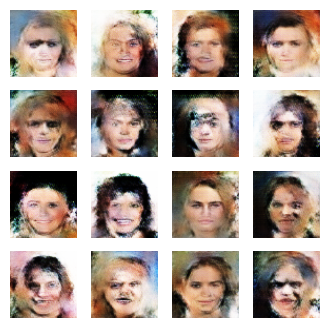

Epoch 9, Gen Loss: 2.0144, Disc Loss: 0.6618, Time: 200.91 sec


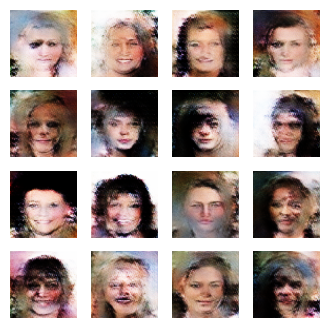

Epoch 10, Gen Loss: 2.2015, Disc Loss: 0.5427, Time: 198.31 sec


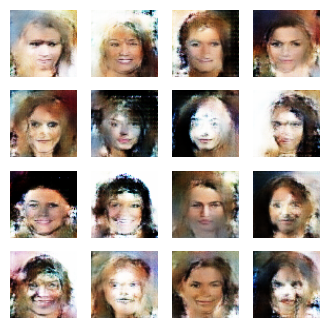

Epoch 11, Gen Loss: 1.8073, Disc Loss: 1.0000, Time: 197.22 sec


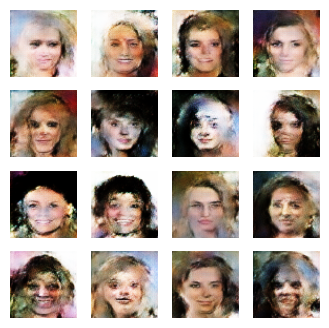

Epoch 12, Gen Loss: 1.6042, Disc Loss: 0.8625, Time: 195.83 sec


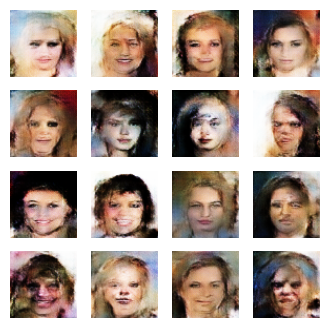

Epoch 13, Gen Loss: 1.0825, Disc Loss: 1.0192, Time: 195.81 sec


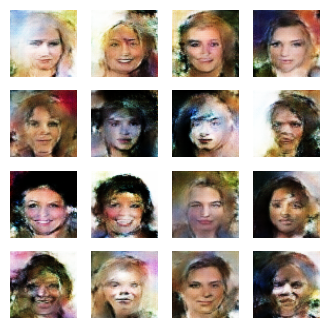

Epoch 14, Gen Loss: 2.0771, Disc Loss: 0.7433, Time: 194.91 sec


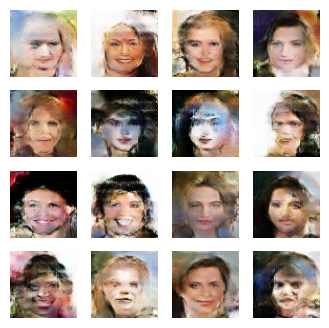

Epoch 15, Gen Loss: 2.2301, Disc Loss: 0.6813, Time: 207.43 sec


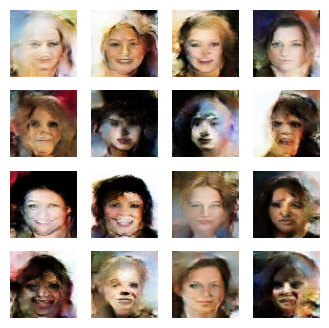

Epoch 16, Gen Loss: 0.8949, Disc Loss: 0.9618, Time: 217.44 sec


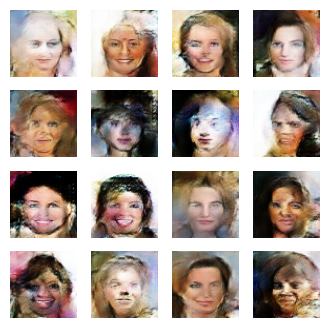

Epoch 17, Gen Loss: 1.3890, Disc Loss: 0.8434, Time: 218.74 sec


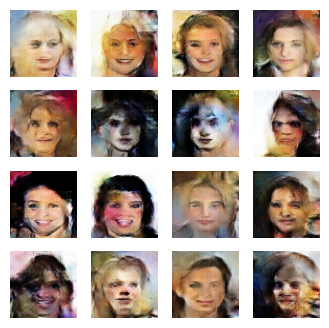

Epoch 18, Gen Loss: 1.1991, Disc Loss: 0.9460, Time: 207.01 sec


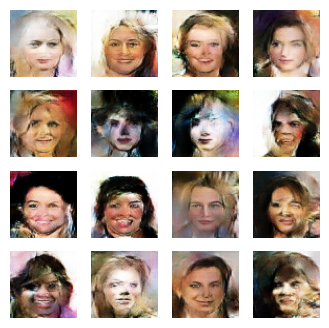

Epoch 19, Gen Loss: 1.5461, Disc Loss: 0.9157, Time: 210.03 sec


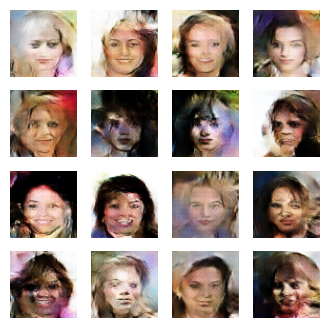

Epoch 20, Gen Loss: 1.4066, Disc Loss: 0.9131, Time: 222.07 sec


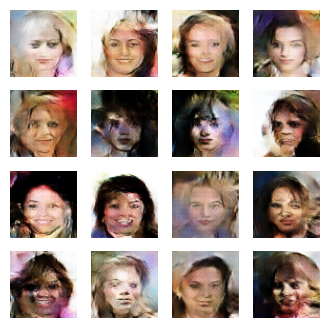

Epoch 20, Gen Loss: 1.4066, Disc Loss: 0.9131, Time: 222.28 sec


In [ ]:
train(train_dataset,epochs)

In [ ]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"Checkpoint restored from {latest_checkpoint}")
else:
    print("No checkpoint found.")


Checkpoint restored from C:\ML\checkpoints\ckpt-5


In [ ]:
print(gen_losses[-1])
print(disc_losses[-1])

1.4066033
0.91312987


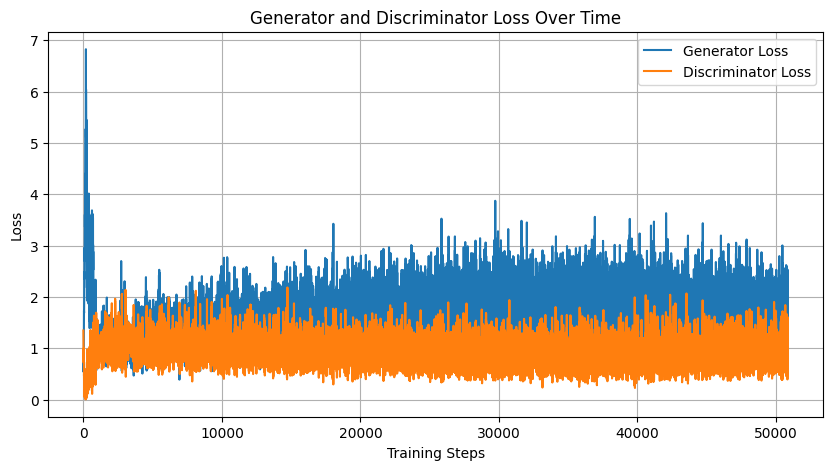

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def test_generator(generator, n_images=16, noise_dim=100):
    noise = tf.random.normal([n_images, noise_dim])
    generated_images = generator(noise, training=False)

    # Normalize the images for display,they are in [-1, 1]
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(4, 4))
    for i in range(n_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, :])
        plt.axis('off')
    plt.suptitle("Generated Images")
    plt.show()


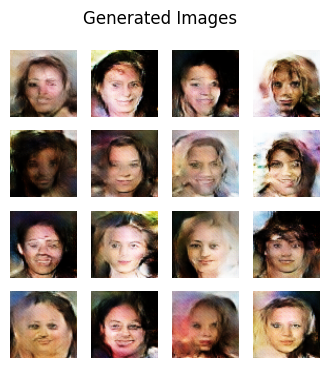

In [ ]:
test_generator(generator)